# Lab 7: Estimating Causal Effects via Instrumental Variables
Welcome to the seventh DS102 lab! 

The goals of this lab is to implement and get better understanding of instrumental variables discussed in [Discussion 06](https://piazza.com/class/k5ofad3nps24c1?cid=199). We highly recommend that you watch the video for [Discussion 06](https://piazza.com/class/k5ofad3nps24c1?cid=199) before attempting this lab.

The code you need to write is commented out with a message "TODO: fill in".


## Course Policies

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** by adding a cell below.

**Submission**: to submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Thursday March 19, 2020 at 11:59 PM.**

Write collaborator names here.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
%matplotlib inline

# Instrumental Variables Background

Suppose that we measure $X_1$, the number of books a student read in the last year, and we are intrested in determing how $X_1$ affects an observed target outcome $Y$, the student's SAT score. The effect we are interested in is **causal** because we want to know how $Y$ changes if all randomness other than $X_1$ remains fixed, and only $X_1$ changes. We will refer to $X_1$ as the "treatment". In general, $X_1$ might be multi-dimensional, however for the purpose of this exercise we take $X_1 \in\mathbb{R}$.

Suppose there's also a confounder $X_2$, which is the income of the student's family. We don't observe $X_2$, but it affects both the number of books the student reads (wealthier families may have more access to books) and the student's SAT score (wealthier students may have more access to SAT tutoring).

We assume that the outcome is generated as a linear function of the confounder $X_2$ and treatment $X_1$, with additive noise $\epsilon$:
$$$$
$$Y = \beta_1 X_1 + \beta_2 X_2 + \epsilon.$$

The goal is to estimate $\beta_1$, the true causal effect of the number of books a student reads on their SAT score.

### Danger of bias
As we saw in Discussion 06, if the confounder $X_2$ is highly correlated with $X_1$, performing ordinary least squares (OLS) on the observed data $X_1$, $Y$ can lead to very biased results. 

### Instrumental variables (IVs) and two-stage least squares (2SLS)

One way to get around this issue is by using **instrumental variables (IVs)**. A valid instrument $Z$ is a variable which is independent of the confounder $X_2$, and affects $Y$ only through $X_1$. For example, as discussed in Discussion 06, we can create such an instrument $Z$ by employing *encouragement design*, where we randomly select students and encourage them to read by organizing a “readathon” at their school. Let $Z$ be the number of days that the organized readathon lasts for the given student. 

Using the instrumental variable $Z$, we can estimate $\beta_1$ by first "guessing" $X_1$ from $Z$ using ordinary least squares (OLS) (denoted $\hat X_1$), and then regressing $Y$ onto $\hat X_1$ (instead of $X_1$) using OLS as well. This procedure is known as **two-stage least squares (2SLS)**. 

In this lab, we will observe the bias that can occur when naively performing OLS on the observed data $X_1, Y$, and also how employing 2SLS can achieve a better estimate of $\beta_1$.

# 1. Model setup

Suppose that we have historical data from $n=10,000$ different students. Suppose we observe the following variables: 

$X_1^{(i)} =$ number of books the student read in the last year, 

$Z^{(i)} = $ whether or not there was a "readathon" at the student's school, 

$Y^{(i)} = $ the student's SAT score. 

Suppose that the student's family income $X_2^{(i)}$ affects both $X_1^{(i)}$ and $Y^{(i)}$, but is not observed.

In [2]:
n = 10000 # sample size

## Generate the data

Each student participates in a readathon that lasts for $20$ days on average, with a standard deviation of $5$ days:
$$Z^{(i)} \sim \text{Normal}(20,5)$$

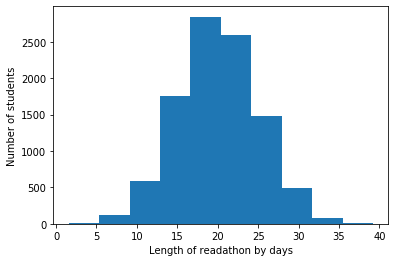

In [4]:
# numpy array of length n, where each entry is Z^{(i)}.
Z = np.random.normal(20,5,n)

plt.xlabel("Length of readathon by days")
plt.ylabel("Number of students")
plt.hist(Z)
plt.show()

Student $i$'s family income is normally distributed, where $X_2^{(i)}$ is the family's annual income (in thousands):
$$X_2^{(i)} \sim \text{Normal}(50, 10)$$ 

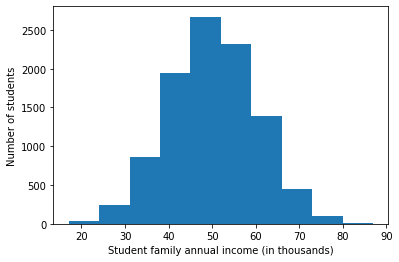

In [6]:
# numpy array of length n, where the ith entry is student i's annual income
X_2 = np.random.normal(50,10,n) 

plt.xlabel("Student family annual income (in thousands)")
plt.ylabel("Number of students")
plt.hist(X_2)
plt.show()

The number of books a student reads is linear in whether or not there was a readathon and the student's family income:
$$X_1 = \gamma_1 Z + \gamma_2 X_2 + \epsilon',$$

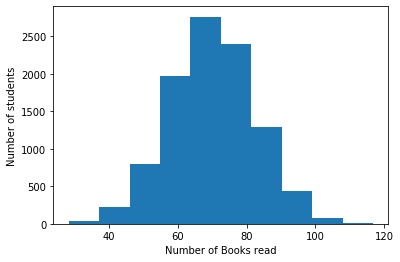

In [7]:
gamma_1 = 1 # number of additional books read per day when there's a readathon
gamma_2 = 1 # number of books read vs. family income
eps_prime = np.random.normal(0,5,n) # noise for number of books read
X_1 = gamma_1 * Z + gamma_2 * X_2 + eps_prime

plt.xlabel("Number of Books read")
plt.ylabel("Number of students")
plt.hist(X_1)
plt.show()

The student's SAT score is linear in the number of books the student read and the student's family income:
$$Y = \beta_1 X_1 + \beta_2 X_2 + \epsilon.$$ 

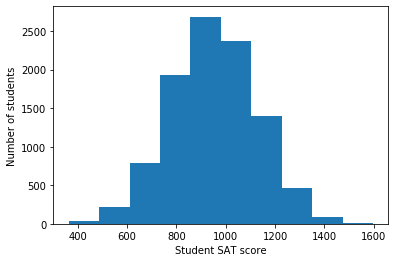

In [9]:
beta_1 = 5 # true relationship between books read and SAT score
beta_2 = 12 # relationship between SAT score and family income
eps = np.random.normal(0,10,n) # noise for SAT score
Y = beta_1 * X_1 + beta_2 * X_2 + eps

plt.xlabel("Student SAT score")
plt.ylabel("Number of students")
plt.hist(Y)
plt.show()

### Goal: estimate $\beta_1$, the true causal effect of the number of books a student reads on their SAT score.

# 2. Naive OLS: OLS on the observed variables $X_1$, $Y$.
The confounding variable $X_2$ (family income) is unfortunately unobserved. We will start by somewhat "naively" attempting to estimate the causal effect $\beta_1$ by using plain linear regression (OLS) on the observed variables $X_1$ and $Y$.

In [10]:
# No TODOs here, just run this cell and understand what this function is doing.
def beta_hat_with_intercept(input_array, target_array):
    """Calculates the OLS estimator parameters. The returned parameters include an intercept term.
    
    Args:
      input_array: numpy array with n entries, where each entry corresponds with a feature value for a given student.
      target_array: numpy array with n entries, where each entry corresponds with a label value for a given student.
    
    Returns:
      numpy array with 2 entries, where the entries are [intercept, beta_hat]. The intercept is a constant term, 
      so the final OLS predictions should be predictions = intercept + beta_hat * input_array.
    """
    ols_features_w_const = sm.add_constant(input_array) # prepend a constant feature for intercept term
    ols_model = sm.OLS(target_array, ols_features_w_const)
    ols_results = (ols_model.fit()).params # predicted coefficients
    return ols_results

In [11]:
# TODO: Fit OLS parameters to predict Y from X_1.
beta_hat_naive_with_intercept = beta_hat_with_intercept(input_array=X_1, target_array=Y)

beta_hat_naive = beta_hat_naive_with_intercept[1]
print("Naive OLS estimate of beta_1:", beta_hat_naive)
print("True beta_1:", beta_1)
print("Absolute error:", np.abs(beta_hat_naive - beta_1))

Naive OLS estimate of beta_1: 12.969040037584913
True beta_1: 5
Absolute error: 7.969040037584913


# 3. Instrumental variables and 2SLS

To eliminate the bias, we turn to instrumental variables. In the first stage, we "predict" the number of books a student read $X_1$ from whether or not they had a readathon, $Z$, producing an estimate $\hat{X_1}$. Then, in the second stage, we regress the SAT score $Y$ onto the predicted number of books read $\hat{X_1}$.

In [12]:
# No TODOs here, just run this call and understand what this function is doing.
def compute_OLS_predictions(input_array, input_params):
    """Calculates OLS predictions from fitted OLS parameters, input_params.
    
    Args:
      input_array: numpy array with n entries, where each entry corresponds with a feature value for a given student.
      input_params: numpy array with 2 entries, where the entries are [intercept, beta_hat]. 
        The intercept is a constant term, so the final OLS predictions should be 
        predictions = intercept + beta_hat*input_array.

    Returns:
      numpy array with n entries containing predictions from input_array.
    """
    predictions = input_params[0] + input_params[1] * input_array 
    return predictions

## 3a) Stage 1: Predict treatment variable $\hat{X}_1$ from instrumental variable $Z$

In [13]:
# Stage 1 of 2SLS.
# TODO: Fit OLS parameters to predict X_1 from Z
X_1_hat_params = beta_hat_with_intercept(input_array=Z, target_array=X_1)

In [15]:
# TODO: Compute predictions using the fitted parameters above.
X_1_hat = compute_OLS_predictions(input_params=X_1_hat_params, input_array=Z)

## 3b) Stage 2: Estimate target $Y$ from predicted treatment variable $\hat{X}_1$

In [16]:
# Stage 2 of 2SLS.
# TODO: Fit OLS parameters to predict Y from the predicted X_1_hat.
beta_hat_2SLS_with_itercept = beta_hat_with_intercept(input_array=X_1_hat, target_array=Y)

beta_hat_2SLS = beta_hat_2SLS_with_itercept[1]
print("2SLS estimate of beta_1:", beta_hat_2SLS)
print("True beta_1:", beta_1)
print("Absolute error:", np.abs(beta_hat_2SLS - beta_1))

2SLS estimate of beta_1: 5.363857297433343
True beta_1: 5
Absolute error: 0.36385729743334316


## 3c) Question: Which technique produced a better estimate of $\beta_1$, naive OLS (part 2) or 2SLS (part 3)?

2SLS (part 3) achieved a much better estimate of $\beta_1$. The absolute error for 2SLS is only 0.36 while 7.96 for the other one. This furthers our claim about bias being able to greatly change our results.
